In [37]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm', '/Users/david/Documents/mastersCode/ubm']


In [38]:
import pickle
from importlib import reload
import numpy as np
from hmmlearn.hmm import GaussianHMM

In [39]:
hmm_data = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/tests/synthetic_tests/unstructured_hmm_data_20_samples.pkl', 'rb'))

In [40]:
curr_train = hmm_data['train_data'][0]

multiple sequences given


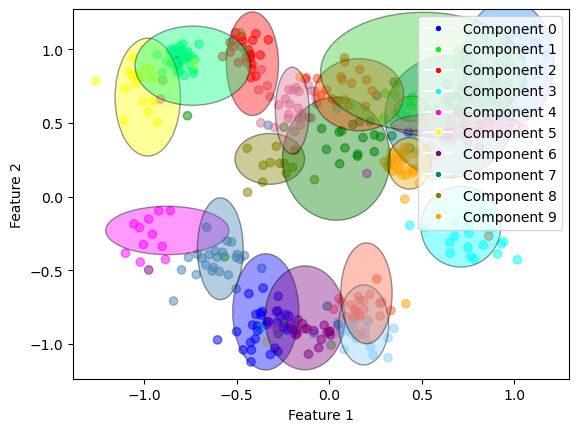

In [41]:
import final.models.hdphmm.bhmm.bhmm as bhmm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
reload(bhmm)
train = curr_train
my_bhmm = bhmm.BayesianHMM(X=train, K=20, iterations=5, alpha0=0.5, kappa0=10,
                           outer_its=1000, verbose=True, convergence_check=200)
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)
plot_hmm.plot_hmm_data(train[0], my_bhmm.Z, my_bhmm.K, my_bhmm.mu, my_bhmm.sigma, feature_a=0, feature_b=1)

In [7]:
hmm_from_trace = my_bhmm.fit()
plot_hmm.plot_hmm_data(curr_train[0], hmm_from_trace.predict(curr_train[0]), hmm_from_trace.n_components, hmm_from_trace.means_, hmm_from_trace.covars_, feature_a=0, feature_b=1)

starting gibbs sampling
outer it:  0
removing empty component(s)
removing empty component(s)
it:  10 score:  0 n-components:  13
removing empty component(s)
it:  20 score:  0 n-components:  12
removing empty component(s)
it:  30 score:  0 n-components:  11
it:  40 score:  0 n-components:  11
it:  50 score:  55.83192024922469 n-components:  11
it:  60 score:  46.20278061447055 n-components:  11
outer it:  1
it:  70 score:  120.76534171584964 n-components:  11
removing empty component(s)
it:  80 score:  0 n-components:  10
it:  90 score:  0 n-components:  10
it:  100 score:  75.3908802811525 n-components:  10
it:  110 score:  76.52020421722646 n-components:  10
it:  120 score:  65.83648384420293 n-components:  10
outer it:  2
it:  130 score:  124.1258486351549 n-components:  10
it:  140 score:  87.54221169457102 n-components:  10
removing empty component(s)
it:  150 score:  0 n-components:  9
it:  160 score:  0 n-components:  9
it:  170 score:  40.70683778906912 n-components:  9
it:  180

In [42]:
import time
# reload(bhmm)
curr_test = hmm_data['test_data']

# ns = np.arange(2,21,1)
# n_inits = np.arange(0,4,1)

alphas = np.array([0.1,1,50,100,500,1000])
ns_alphas = np.arange(len(alphas))
n_inits = np.arange(0,2,1)
K = 30

In [43]:

start_outer = time.time()
results_gibbs_finite = {}
results_per_component = {}
for n in ns_alphas:

    print('calculating for alpha: ', alphas[n])
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(1): # len(hmm_data['train_data'])
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_bhmm = bhmm.BayesianHMM(X=curr_train, K=K, iterations=50, alpha0=alphas[n], kappa0=10, outer_its=1000, verbose=False, convergence_check=200)
            curr_hmm = my_bhmm.fit()
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_bhmm)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components),
        'final_components_max':  models[best_model].n_components
    }
    print('n comps: ', np.mean(final_components), 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_finite['total_time'] = end_outer - start_outer
results_gibbs_finite['components'] = results_per_component
results_gibbs_finite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_finite['component_list'] = ns_alphas


calculating for alpha:  0.1
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  12.601732969284058
multiple sequences given
starting gibbs sampling


/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/numba_wl.py:46: RuntimeWarning: divide by zero encountered in log
  log_probabilities = np.log(initial_dist) + likelihood[0] + beta[0]


convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  6.267090082168579
n comps:  7.5 test_val:  -1531.1507194280343
calculating for alpha:  1.0
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  11.254690885543823
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  14.213502883911133
n comps:  9.0 test_val:  -880.3143428293723
calculating for alpha:  50.0
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  12.060405969619751
multiple sequences given
starting gibbs sampling
convergence criteria met!
Completed gibbs sampling -- Convergence:  True  -- In:  12.442245244979858
n comps:  11.5 test_val:  -799.0296524041844
calculating for alpha:  100.0
multiple sequences given
starting gibbs sampling
convergence criteria met!
Comp

In [14]:
output = open('results_gibbs_finite' + ".pkl", "wb")
pickle.dump(results_gibbs_finite, output)
output.close()

In [10]:
results_gibbs_finite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_finite.pkl', 'rb'))

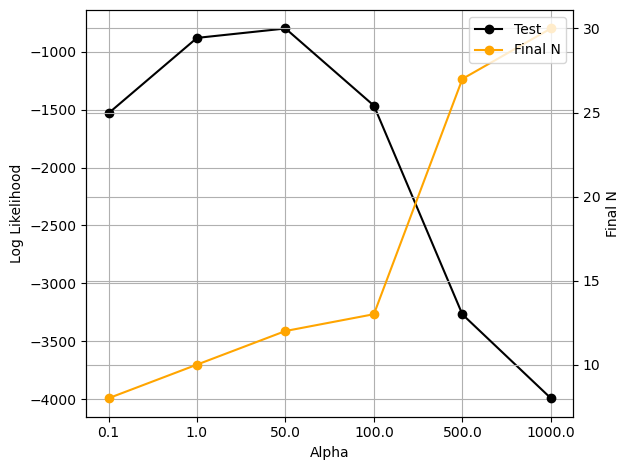

In [49]:
import matplotlib.pyplot as plt

components_results = results_gibbs_finite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = [components_results[some_key]['final_components_max'] for some_key in components_results]

fig, ax = plt.subplots()

# ax.plot(ns_alphas, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns_alphas, test_ll, color='black', label='Test', marker='o')
ax.set_xticks(ns_alphas, alphas)

ax2 = ax.twinx()
ax2.plot(ns_alphas, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))
#
# ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)


ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
# ax.set_title("HMM Gibbs Finite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax.grid(True)  # Enable grid on primary axis
ax2.grid(True)  # Enable grid on secondary axis
ax2.set_ylabel("Final N")
ax.set_xlabel("Alpha")
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()

plt.show()


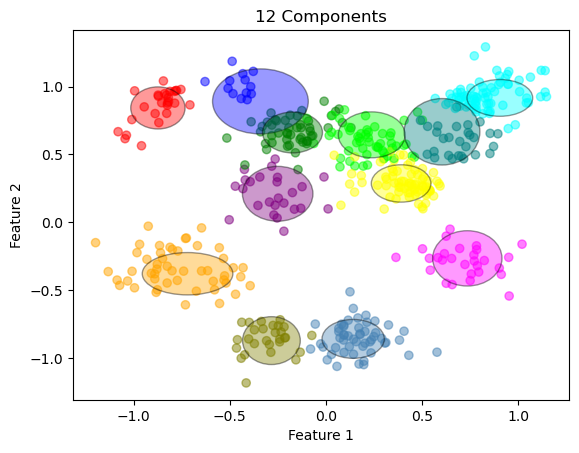

In [45]:
temp = np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])
hmm_temp = results_gibbs_finite['components'][2]['models'][0]
plot_hmm.plot_hmm_data(curr_test[1], hmm_temp.predict(curr_test[1]), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='12 Components')

In [46]:
print('max finite gibbs test value: ', np.max([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']]), (np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])), results_gibbs_finite['total_time'])

max finite gibbs test value:  -799.0296524041844 2 152.3236780166626


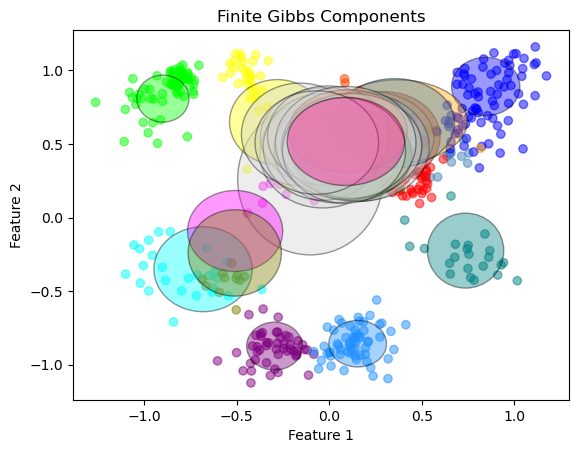

In [18]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])
hmm_temp = results_gibbs_finite['components'][4]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='Finite Gibbs Components')

In [10]:
# not working yet :/

import final.models.hdphmm.hdphmmda.hdp_hmm_da as hdp_hmm_da
reload(hdp_hmm_da)

# my_bhmm = bhmm.BayesianHMM(X=train, K=20, iterations=5, alpha0=0.5, kappa0=10,
#                            outer_its=1000, verbose=True, convergence_check=200)
# import final.models.hdphmm.helpers.plot_hmm as plot_hmm
# reload(plot_hmm)
# plot_hmm.plot_hmm_data(train[0], my_bhmm.Z, my_bhmm.K, my_bhmm.mu, my_bhmm.sigma, feature_a=0, feature_b=1)

my_hdphmm_da = hdp_hmm_da.InfiniteDirectSamplerHMM(hmm_data['train_data'][0], K=20, outer_its=10, iterations=20,convergence_check=200, verbose=True)
my_hdphmm_da_fitted_hmm = my_hdphmm_da.fit()

multiple sequences given


In [24]:
output = open('my_hdphmm_da_fitted_hmm' + ".pkl", "wb")
pickle.dump(my_hdphmm_da_fitted_hmm, output)
output.close()

In [19]:
import final.models.hdphmm.hdphmmwl.hdphmmwl as hdphmmwl
reload(hdphmmwl)

my_hdphmm_wl = hdphmmwl.HDPHMMWL(hmm_data['train_data'][0], K=20, outer_its=100, iterations=50, convergence_check=200, max_it=1000)

multiple sequences given


In [35]:
curr_hmm = my_hdphmm_wl.fit_multiple(verbose=False)
curr_hmm.score(np.concatenate(curr_test))
plot_hmm.plot_hmm_data(data_temp, curr_hmm.predict(data_temp), curr_hmm.n_components, curr_hmm.means_, curr_hmm.covars_, feature_a=0, feature_b=1, legend=False, title='Infinite Gibbs Components')

starting gibbs sampling


KeyboardInterrupt: 

In [20]:
import time

# ns = np.arange(2,21,1)
# n_inits = np.arange(0,2,1)

In [22]:

start_outer = time.time()
results_gibbs_infinite = {}
results_per_component = {}

for n in ns_alphas:
    print('calculating for n: ', n)
    sbp = {
        "gamma0": alphas[n],
        "alpha0": 10,
        "kappa0": 10,
    }
    start_inner = time.time()
    total_inits = 0
    lls = []
    models = []
    models_gibbs = []
    final_components = []

    for cv_index in range(len(hmm_data['train_data'])):
        curr_train = hmm_data['train_data'][cv_index]
        curr_val = hmm_data['val_data'][cv_index]

        for i in n_inits:
            total_inits += 1

            my_hdphmm_wl = hdphmmwl.HDPHMMWL(curr_train, K=K, outer_its=100, iterations=50,
                                             convergence_check=200, max_it=1000, )
            curr_hmm = my_hdphmm_wl.fit_multiple()
            ll = curr_hmm.score(np.concatenate(curr_val))

            # append
            lls.append(ll)
            models.append(curr_hmm)
            models_gibbs.append(my_hdphmm_wl)

            # final components from A matrix
            final_components.append(curr_hmm.n_components)

    best_model = np.argmax(lls)
    average_score = np.mean(lls)
    end_inner = time.time()
    results_per_component[n] = {
        'lls': lls,
        'models': models,
        'models_gibbs': models_gibbs,
        'time': (end_inner - start_inner),
        'test': models[best_model].score(np.concatenate(curr_test)),
        'avg_val': average_score,
        'final_components': final_components,
        'final_components_mean': np.mean(final_components),
        'final_components_max':  models[best_model].n_components
    }
    print('n comps: ', np.mean(final_components), 'test_val: ', results_per_component[n]['test'])

end_outer = time.time()
results_gibbs_infinite['total_time'] = end_outer - start_outer
results_gibbs_infinite['components'] = results_per_component
results_gibbs_infinite['total_its'] = len(hmm_data['train_data']) * len(n_inits)
results_gibbs_infinite['component_list'] = ns_alphas


calculating for n:  0
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  24.558451414108276
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  24.13561701774597
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  24.175843954086304
multiple sequences given
starting gibbs sampling
convergence criteria met!
completed gibbs sampling in  13.74997591972351
n comps:  10.75 test_val:  -703.1254277520794
calculating for n:  1
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  23.466047048568726
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  24.54646134376526
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  23.080129146575928
multiple sequences given
starting gibbs sampling
max it met!
completed gibbs sampling in  24.00684881210327
n comps:  11.0 test_val:  -1

In [20]:
output = open('results_gibbs_infinite' + ".pkl", "wb")
pickle.dump(results_gibbs_infinite, output)
output.close()

In [23]:
results_gibbs_infinite = pickle.load(open(r'/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/bhmm/testing/results_gibbs_infinite.pkl', 'rb'))

In [51]:
import matplotlib.pyplot as plt

components_results = results_gibbs_infinite['components']
color1, color2, color3 = plt.cm.viridis([0, .5, .9])

avg_val_ll = [components_results[some_key]['avg_val'] for some_key in components_results]
test_ll = [components_results[some_key]['test'] for some_key in components_results]
final_components = np.array([components_results[some_key]['final_components_max'] for some_key in components_results])
# argmax =  np.array([np.argmax(components_results[some_key]['lls']) for some_key in components_results])
# final_components = np.array([components_results[some_key]['final_components'] for some_key in components_results])
# argmax_components = [final_components[i, argmax[i]] for i in range(len(argmax))]

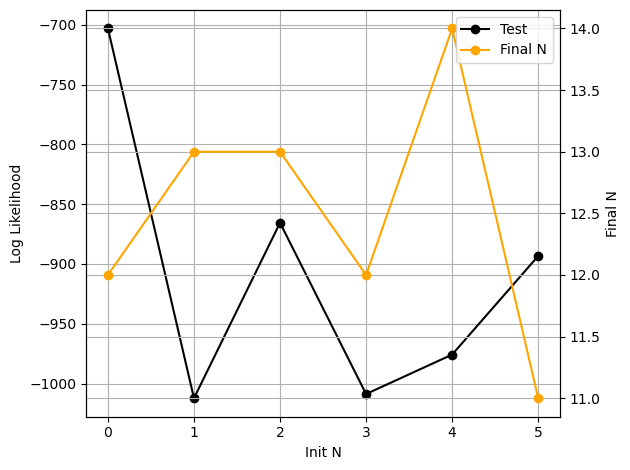

In [52]:
fig, ax = plt.subplots()

# ax.plot(ns, avg_val_ll, color='blue', label='Val', marker='o')
ax.plot(ns_alphas, test_ll, color='black', label='Test', marker='o')

ax2 = ax.twinx()
ax2.plot(ns_alphas, final_components, color='orange', label='Final N', marker='o')
# ax2.set_ylim(0,15)
# ax2.set_yticks(np.arange(0,15,1))

# ax.set_xticks(np.arange(4,21,4))

# ax3 = ax.twinx()
# ax3.plot(ns, elbo, label='Elbo', marker='o', color='green')
# ax3.set_ylabel("Elbo")
# ax3.spines['right'].set_position(('outward', 60))
# ax3.set_ylim(-0.1,0.15)

ax.legend(handles=ax.lines + ax2.lines) # + ax3.lines)
# ax.set_title("HMM Gibbs Infinite Validate/Test")
ax.set_ylabel("Log Likelihood")
ax2.set_ylabel("Final N")
ax.set_xlabel("Init N")
ax.grid(True)  # Enable grid on primary axis
ax2.grid(True)  # Enable grid on secondary axis
all_axes = fig.get_axes()
for axis in all_axes:
    legend = axis.get_legend()
    if legend is not None:
        legend.remove()
        all_axes[-1].add_artist(legend)
fig.tight_layout()
plt.show()


In [29]:
print('max finite gibbs test value: ', np.max([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']]), (np.argmax([results_gibbs_finite['components'][some_key]['test'] for some_key in results_gibbs_finite['components']])), results_gibbs_finite['total_time'])

max finite gibbs test value:  520.4000022473684 13 942.6713109016418


In [28]:
components_results = results_gibbs_finite['components']
some_std_avg = np.mean([np.std(components_results[some_key]['lls']) for some_key in components_results], axis=0)

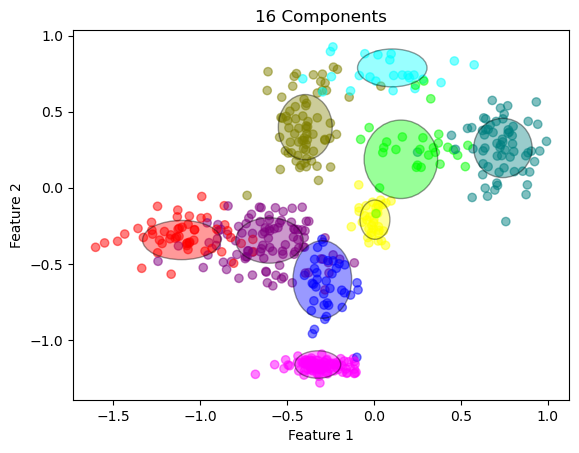

In [19]:
import final.models.hdphmm.helpers.plot_hmm as plot_hmm
reload(plot_hmm)

data_temp = hmm_data['train_data'][0][0]

temp = np.argmax([results_gibbs_infinite['components'][some_key]['test'] for some_key in results_gibbs_infinite['components']])
hmm_temp = results_gibbs_infinite['components'][15 + 2]['models'][0]
plot_hmm.plot_hmm_data(data_temp, hmm_temp.predict(data_temp), hmm_temp.n_components, hmm_temp.means_, hmm_temp.covars_, feature_a=0, feature_b=1, legend=False, title='16 Components')